In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu
from scroutines import powerplots

import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [3]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': 's',
            'DL': '^',
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def select_genes(self, selected_genes):
        """
        """
        # type_idx = basicu.get_index_from_array(self.types, selected_types)
        gene_idx = basicu.get_index_from_array(self.genes, selected_genes)
        assert np.any(gene_idx != -1)
        
        vals = self.bigtensor[:,:, :, gene_idx] # cond by rep
        return vals
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
        assert gene_idx != -1

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.set_xticks(self.conds_time[sel])
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-k')

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color='k',
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        
    def plot_one_simple(self, ax, selected_type, selected_gene, annotate=True, color='k'):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
        assert gene_idx != -1

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-', color=color)

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color=color,
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [4]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_subclass_v2.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_subclass_v2.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo0 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(9, 2, 20, 16572)


In [5]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo1 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(11, 3, 18, 16572)


# plot

In [6]:
def plot_combined(bo0, bo1, gene, type0, type1):
    xticks = [6,10,14,17,21,28,38]
    
    fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
    ax = axs[0]
    bo0.plot_one_simple(ax, type0, gene, color='k')
    bo1.plot_one_simple(ax, type0, gene, annotate=False, color='C1')
    ax.set_xticks(xticks)
    ax.grid(axis='x')

    ax = axs[1]
    bo0.plot_one_simple(ax, type1, gene, annotate=False, color='k')
    bo1.plot_one_simple(ax, type1, gene, annotate=False, color='C1')
    ax.set_xticks(xticks)
    ax.grid(axis='x')
    plt.show()

In [7]:
def plot_combined_v2(bo0, gene, types, sharey=False):
    xticks = [6,10,14,17,21,28,38]
    
    n = len(types)
    fig, axs = plt.subplots(1,n,figsize=(n*5,1*4), sharex=True, sharey=sharey)
    for i in range(n):
        ax = axs[i]
        thistype = types[i]
        bo0.plot_one_simple(ax, thistype, gene, color='k')
        ax.set_xticks(xticks)
        ax.grid(axis='x')

    plt.show()

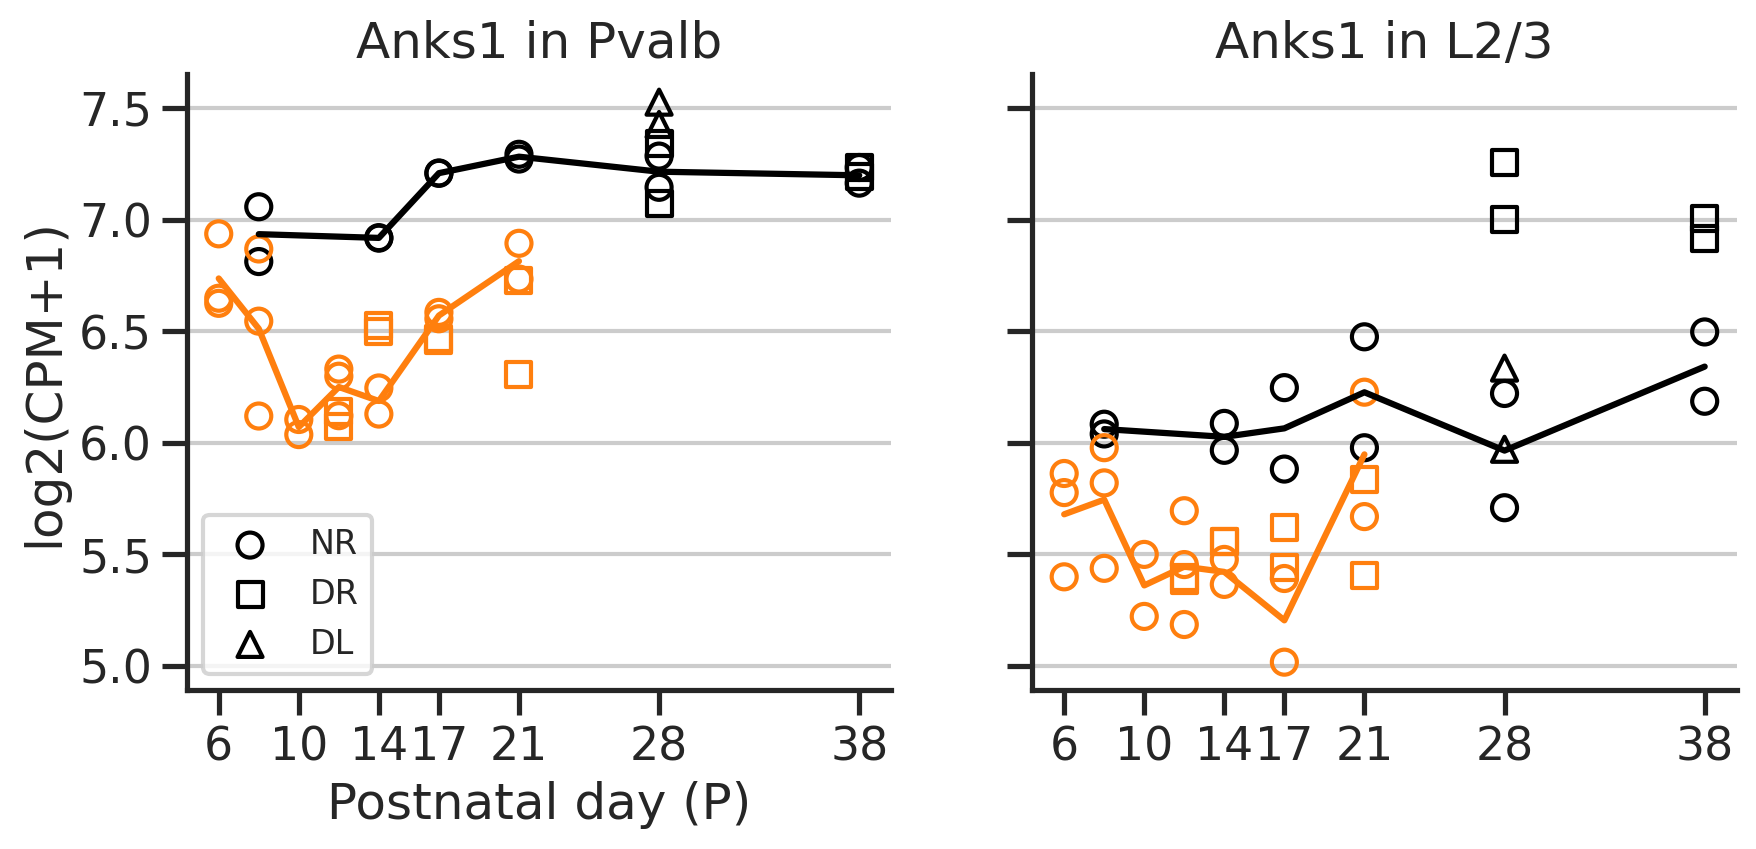

In [8]:
plot_combined(bo0, bo1, 'Anks1', 'Pvalb', 'L2/3')

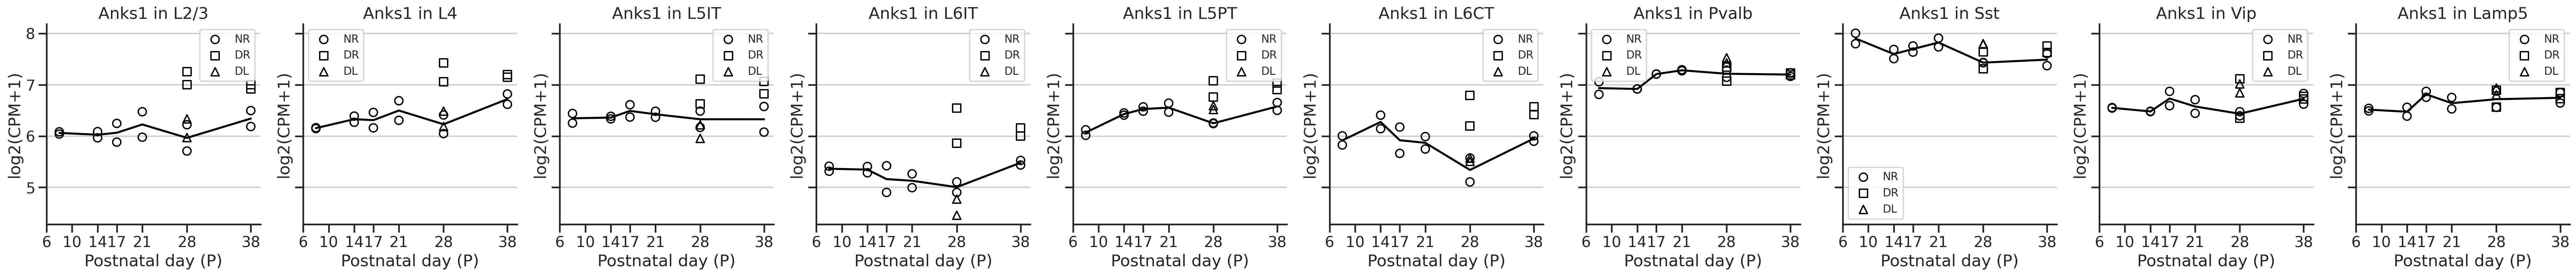

In [9]:
plot_combined_v2(bo0, 'Anks1', 
                 ['L2/3', 'L4', 'L5IT', 'L6IT', 
                  'L5PT', 'L6CT',
                  'Pvalb', 'Sst', 'Vip', 'Lamp5',
                 ], sharey=True)

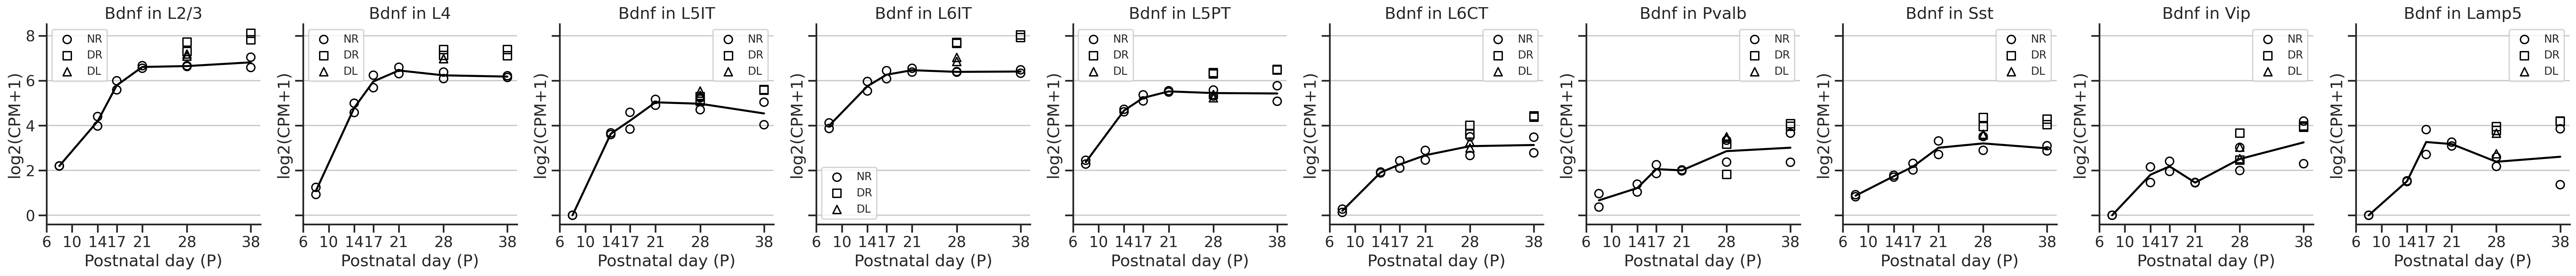

In [10]:
genes = [
    # 'Nrxn1',
    'Bdnf',
]
for gene in genes:
    plot_combined_v2(bo0, gene, 
                     ['L2/3', 'L4', 'L5IT', 'L6IT', 
                      'L5PT', 'L6CT',
                      'Pvalb', 'Sst', 'Vip', 'Lamp5',
                     ], sharey=True)

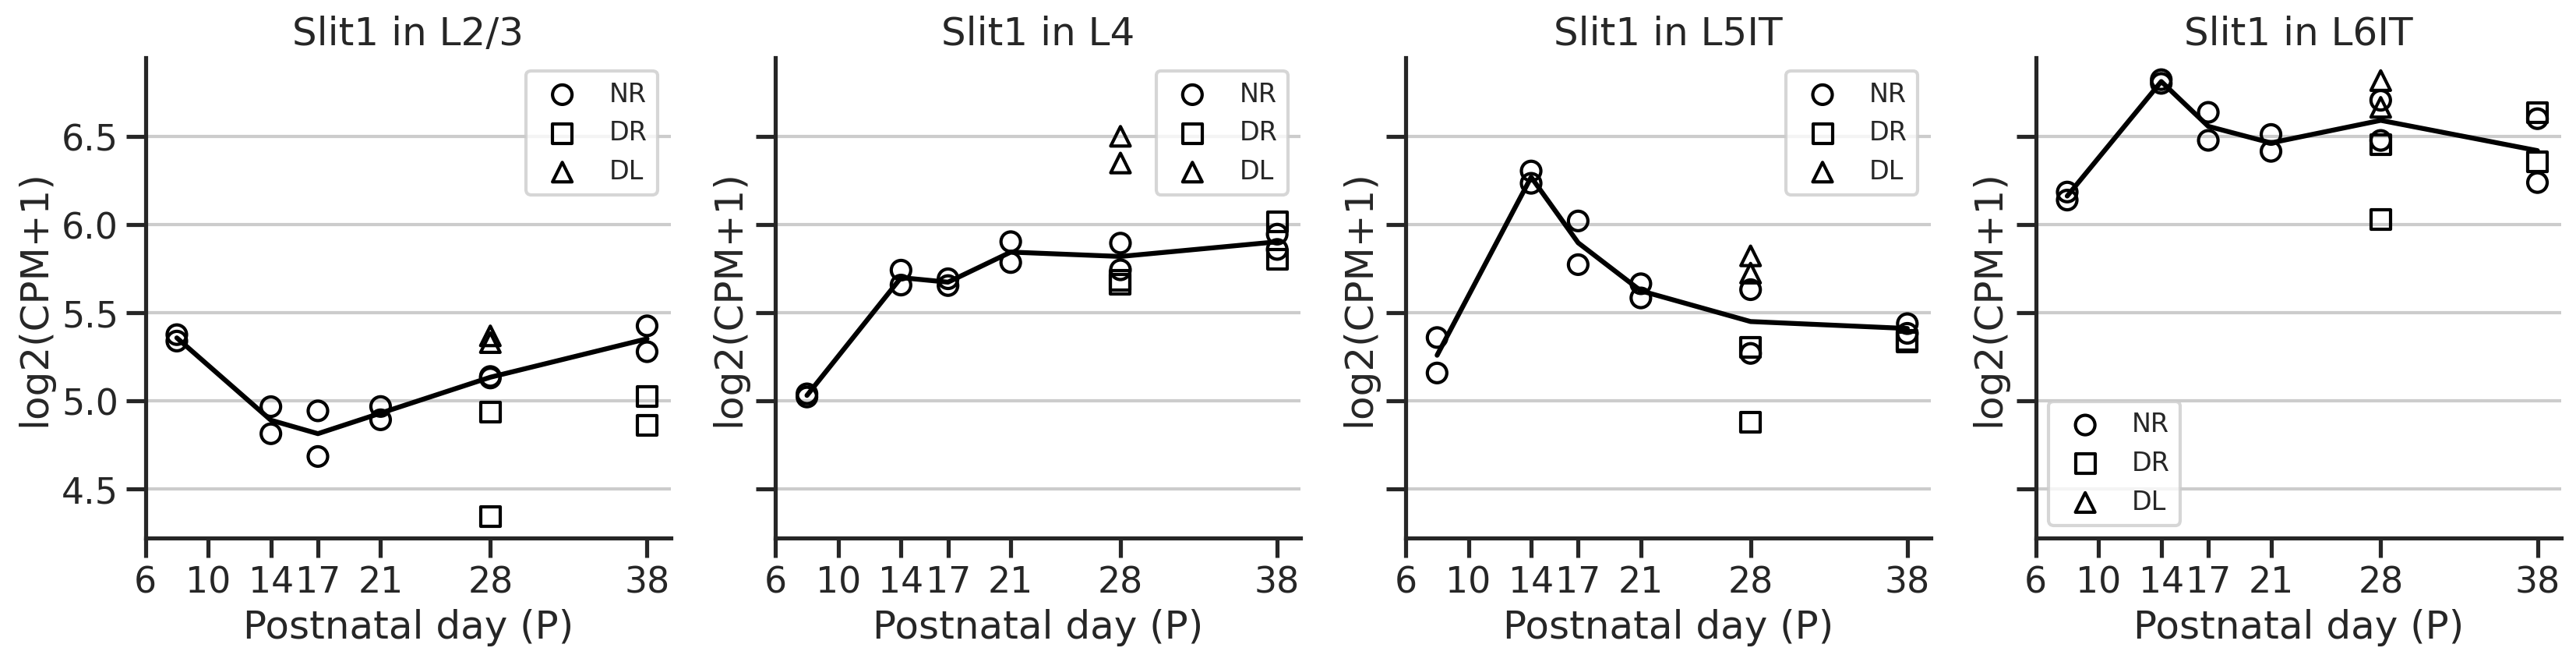

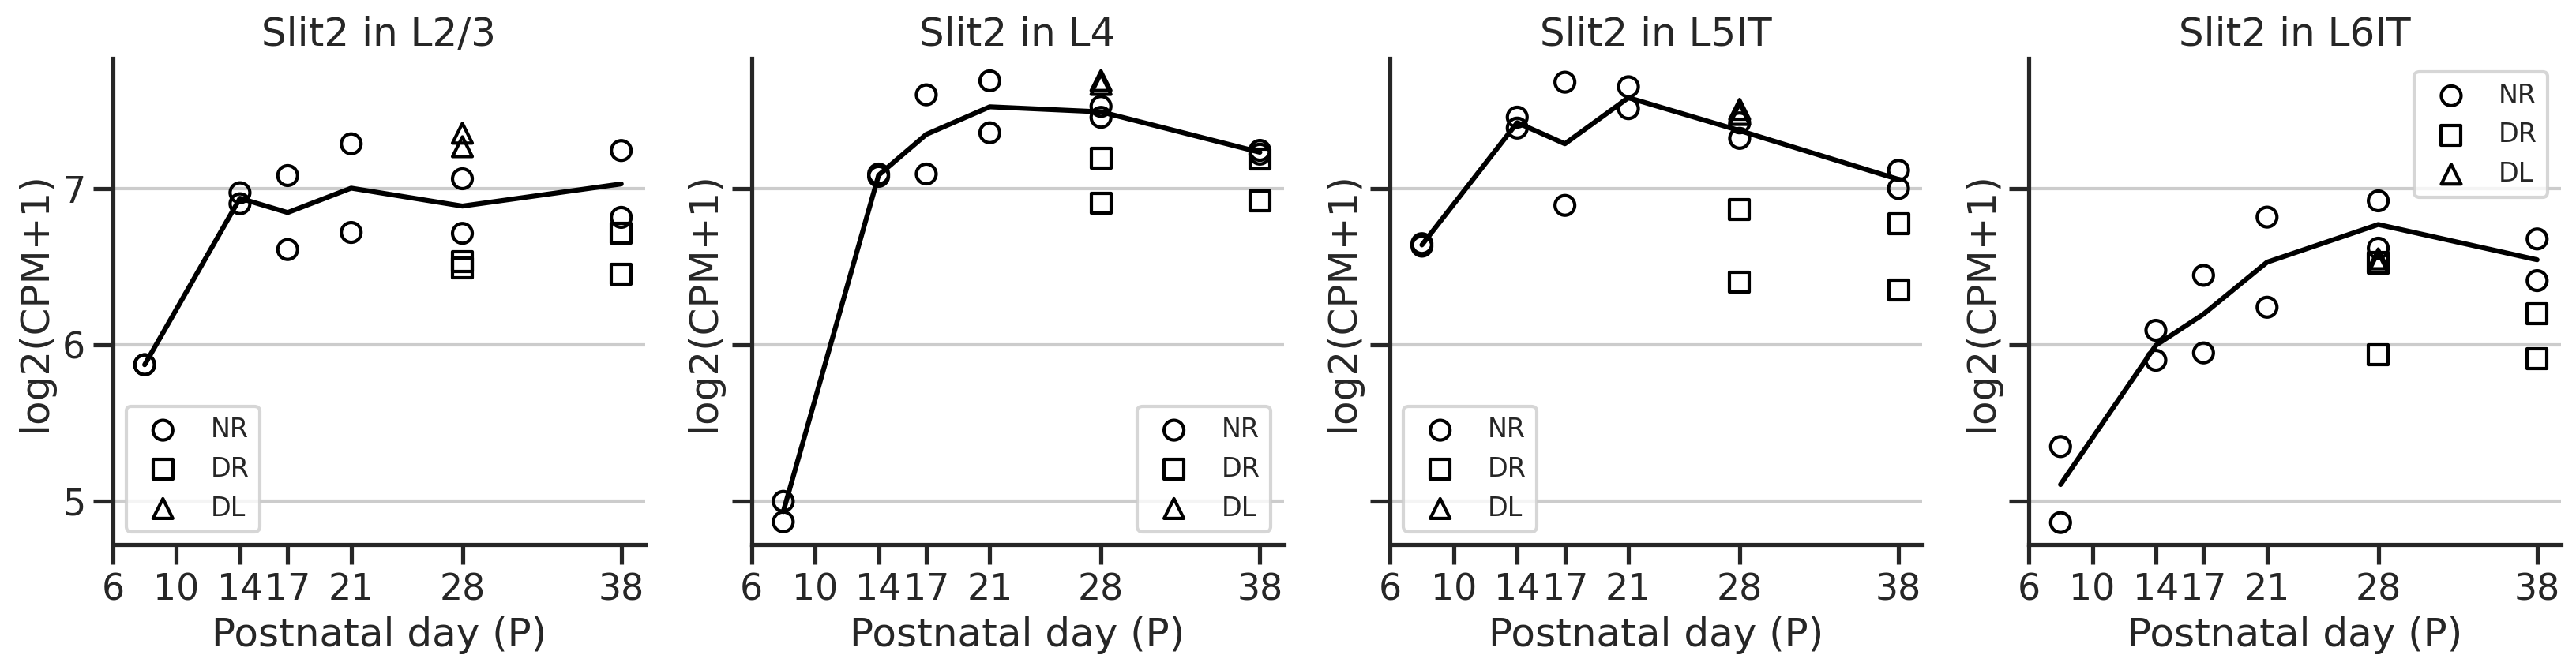

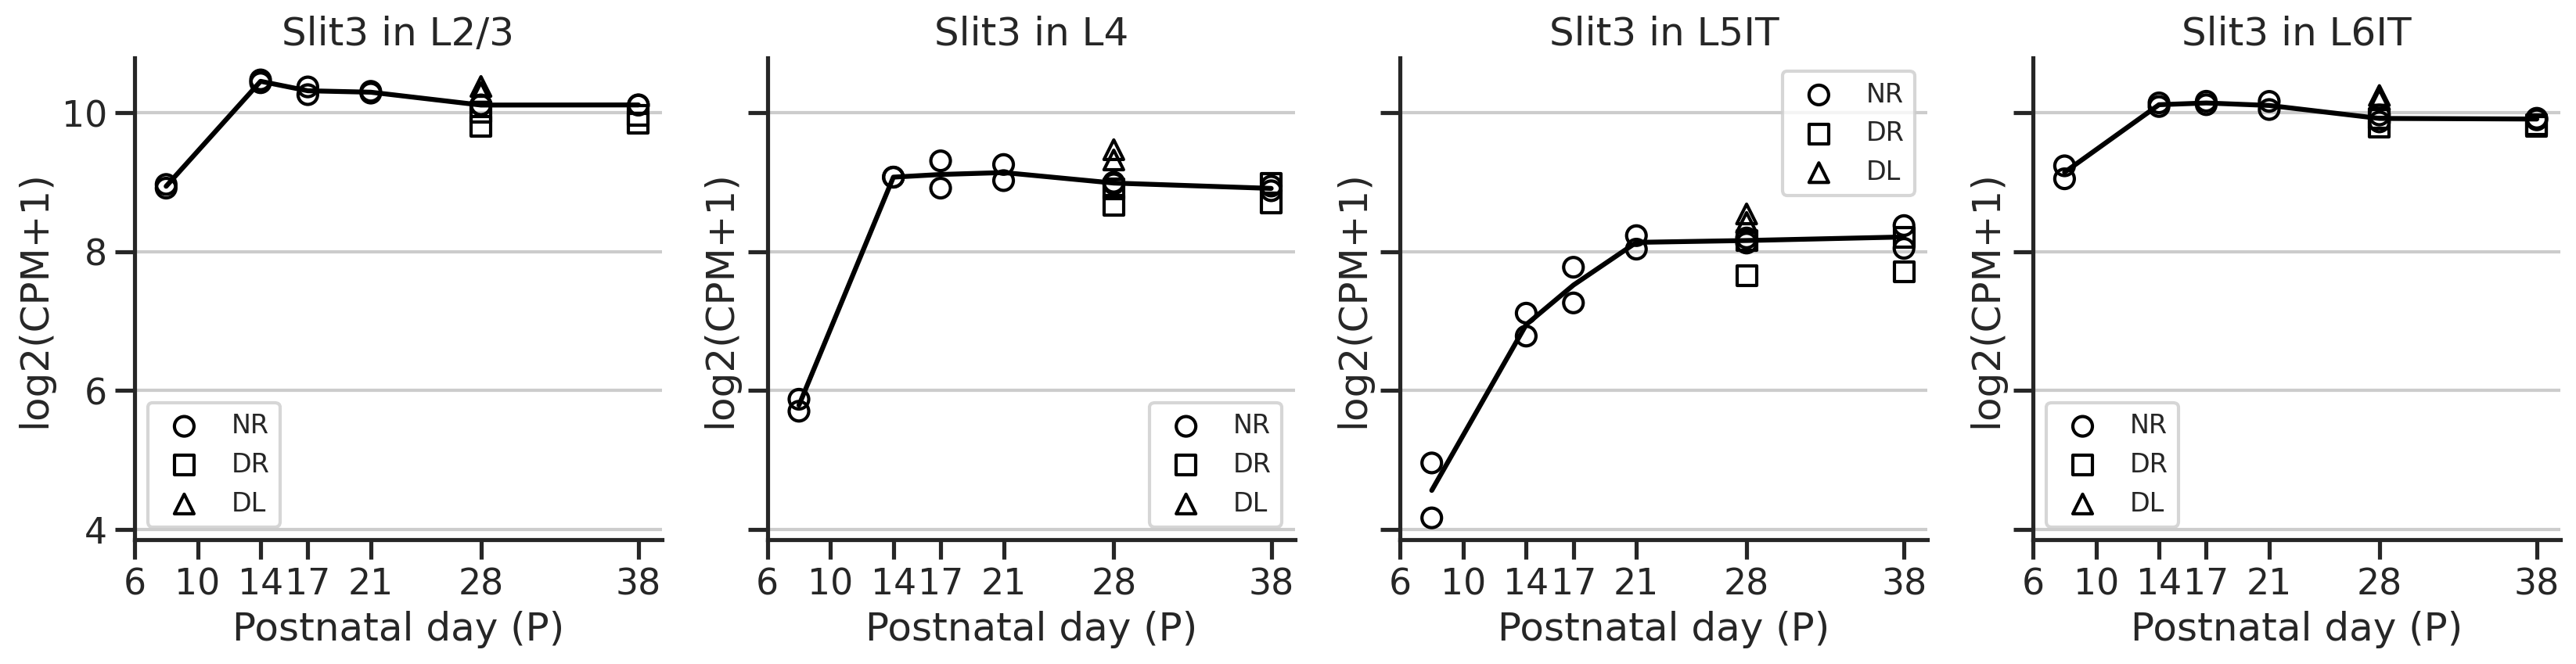

In [10]:
# genes = [
#     'Anks1', 
#     'Egfr', 
#     'Ubash3b', 
# ]

# genes = ['Scnn1a', ]
# genes = np.sort([g for g in bo0.genes if g.startswith('Scn')])

# genes = np.sort([g for g in bo0.genes if g.startswith('Gria')])
# genes = np.sort([g for g in bo0.genes if g.startswith('Grid')])
# genes = np.sort([g for g in bo0.genes if g.startswith('Grin')])
# genes = np.sort([g for g in bo0.genes if g.startswith('Glr')])
# genes = np.sort([g for g in bo0.genes if (g.startswith('Slit') and not g.startswith('Slitrk'))])

genes = ['Slit1', 'Slit2', 'Slit3']
for gene in genes:
    plot_combined_v2(bo0, gene, 
                     ['L2/3', 'L4', 'L5IT', 'L6IT', 
                      # 'L5PT', 'L6CT',
                      # 'Pvalb', 'Sst', 'Vip', 'Lamp5',
                     ], sharey=True)

In [67]:
bo1.types, bo1.genes, bo1.conds_anno, bo1.conds_time

(array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
        'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
        'Sst', 'Vip'], dtype='<U5'),
 array(['Xkr4', 'Gm1992', 'Rp1', ..., 'Tmlhe', 'AC149090.1',
        'CAAA01118383.1'], dtype='<U14'),
 array(['NR', 'NR', 'NR', 'DR', 'NR', 'DR', 'NR', 'DR', 'NR', 'DR', 'NR'],
       dtype='<U2'),
 array([ 6,  8, 10, 12, 12, 14, 14, 17, 17, 21, 21]))

In [70]:
selected_genes = ['Slit1', 'Slit2', 'Slit3']
vals = bo1.select_genes(selected_genes)[0]
vals_mean = np.mean(vals, axis=0)
vals.shape, vals_mean.shape


((3, 18, 3), (18, 3))

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures/250409/bar_slit_2025-08-08.pdf


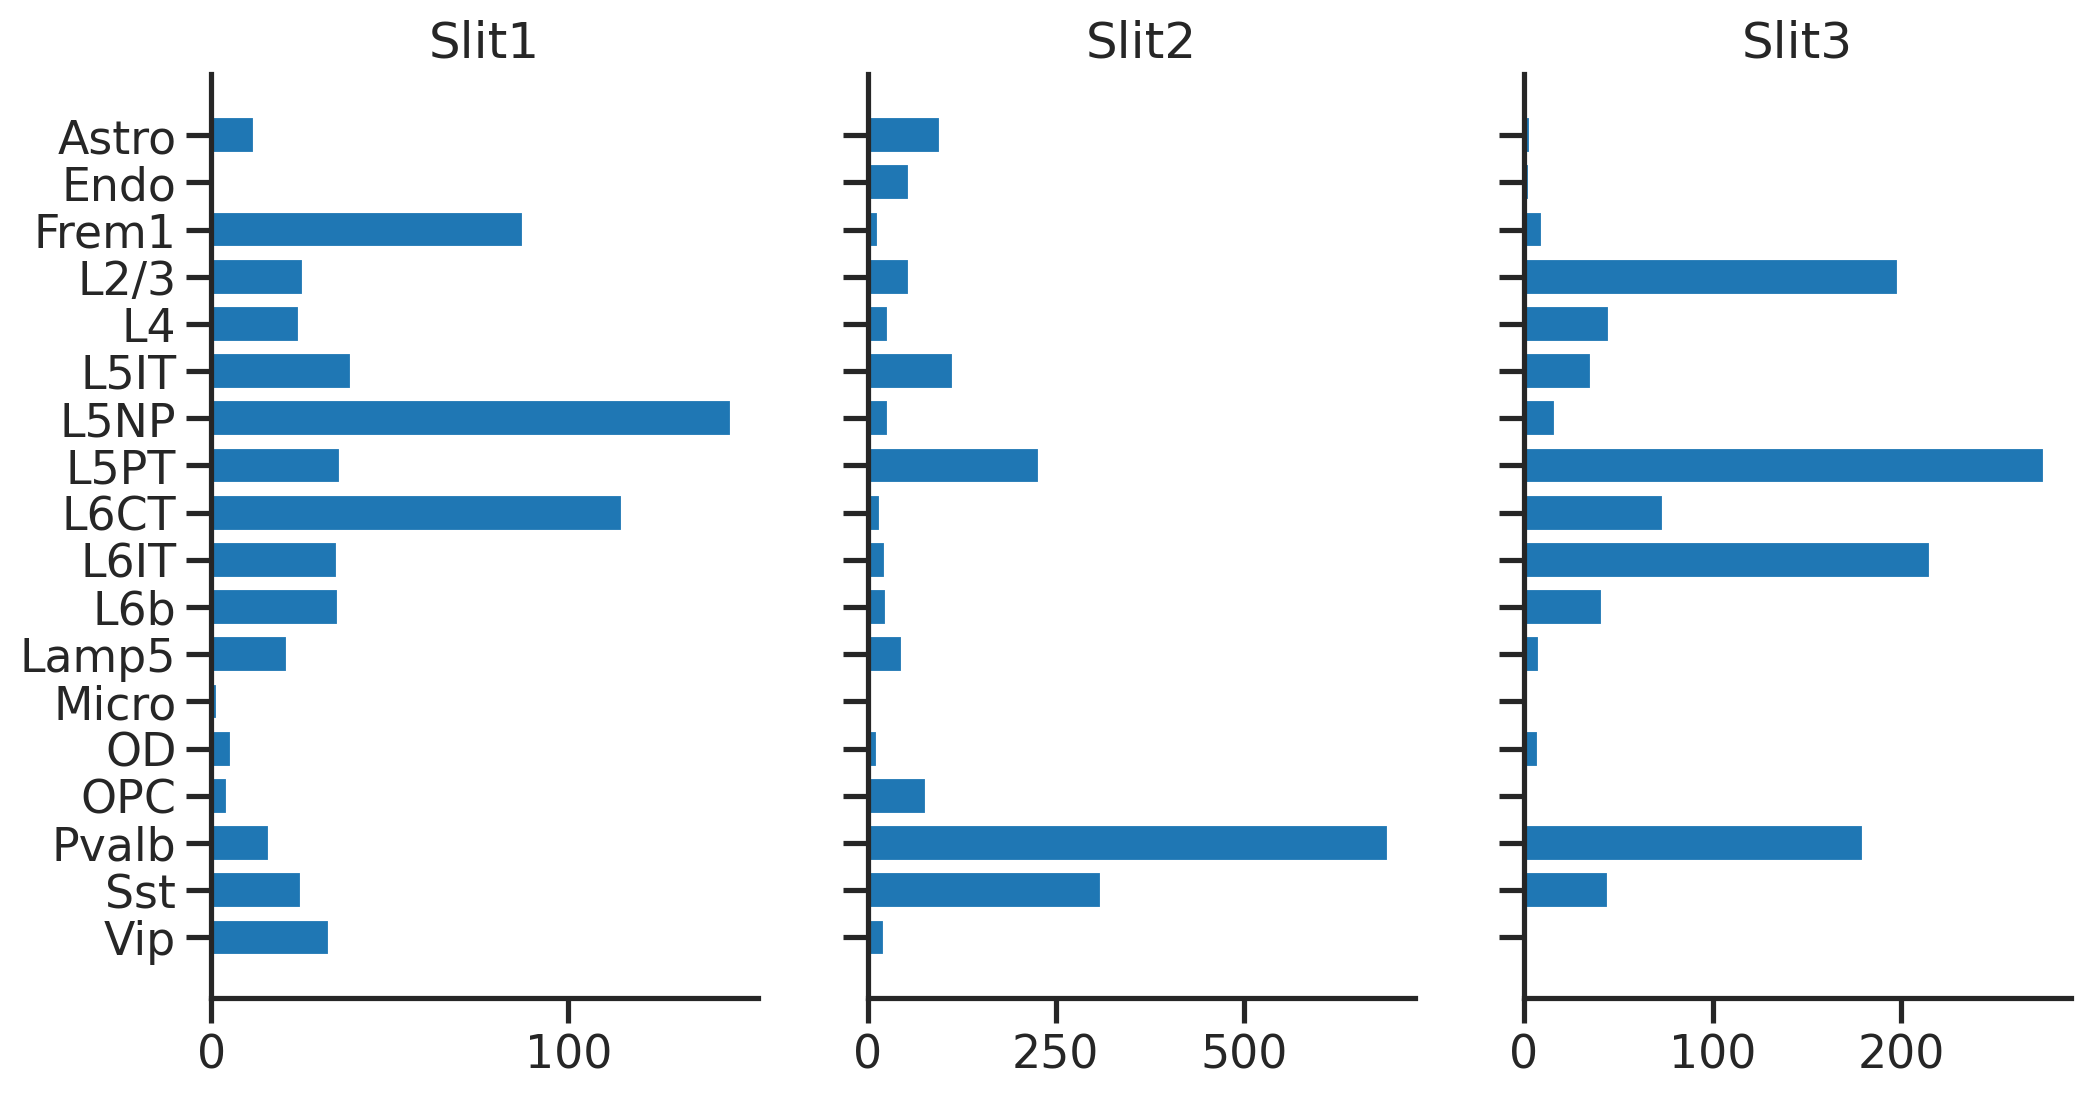

In [94]:
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures/250409"

fig, axs = plt.subplots(1,3,figsize=(3*4,1*6), sharey=True) #, sharex=True)
for i in range(3): 
    ax = axs[i]
    ax.barh(np.arange(18), np.power(2, vals_mean[:,i])-1)
    ax.set_yticks(np.arange(18))
    ax.set_yticklabels(bo1.types, rotation=0)
    ax.set_title(selected_genes[i])
    sns.despine(ax=ax)
    ax.grid(False)
ax.invert_yaxis()
output = os.path.join(outfigdir, 'bar_slit.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

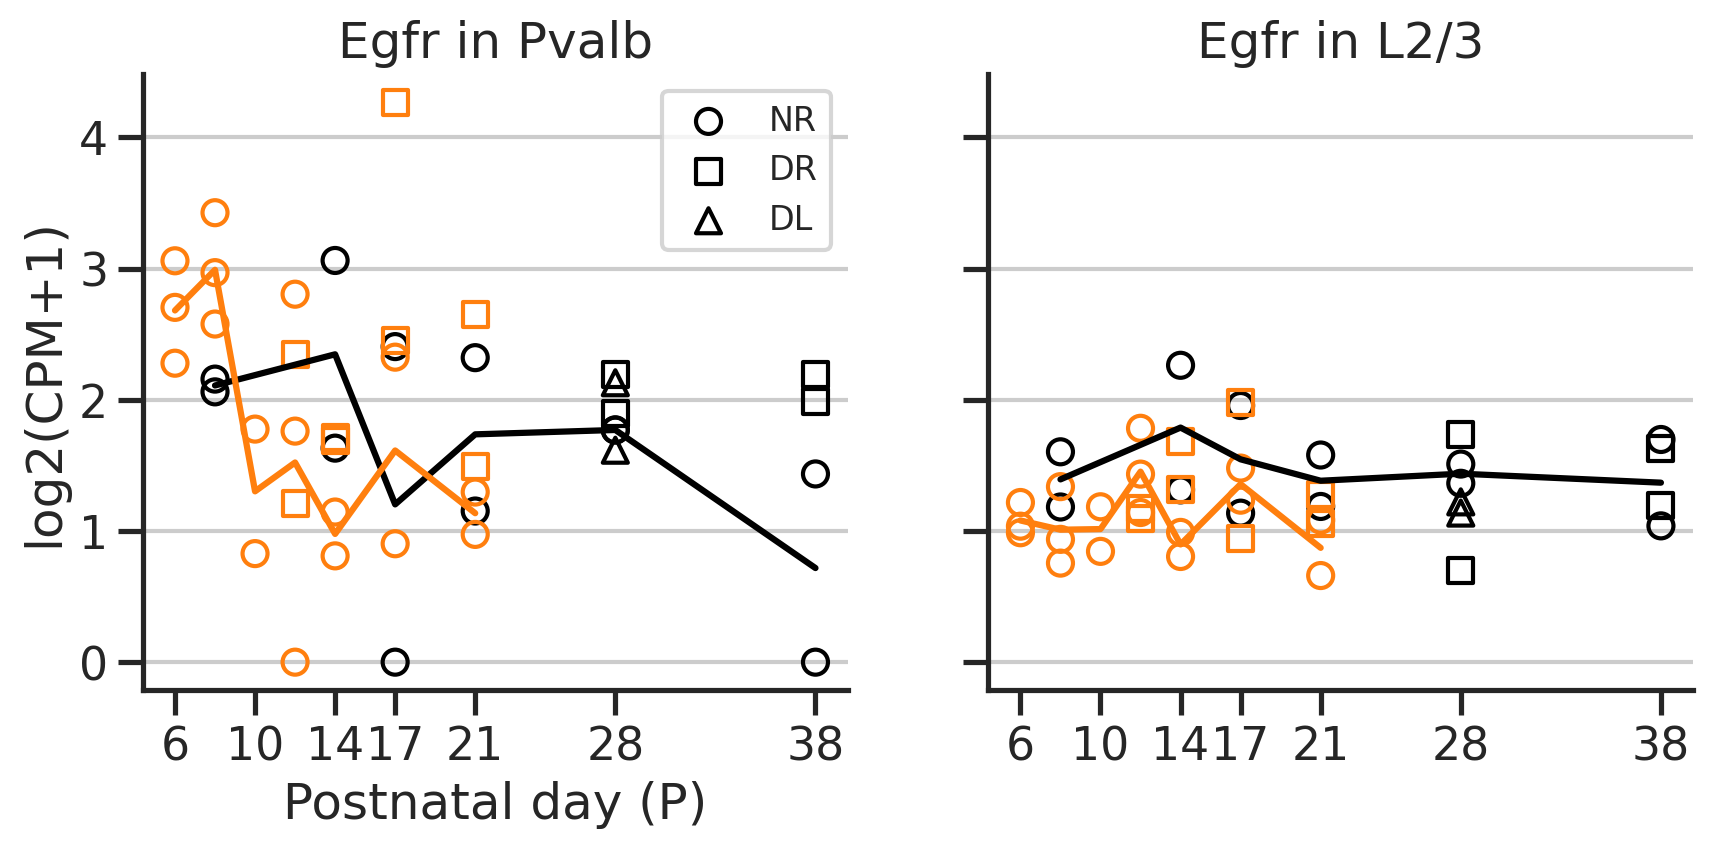

In [12]:
plot_combined(bo0, bo1, 'Egfr', 'Pvalb', 'L2/3')

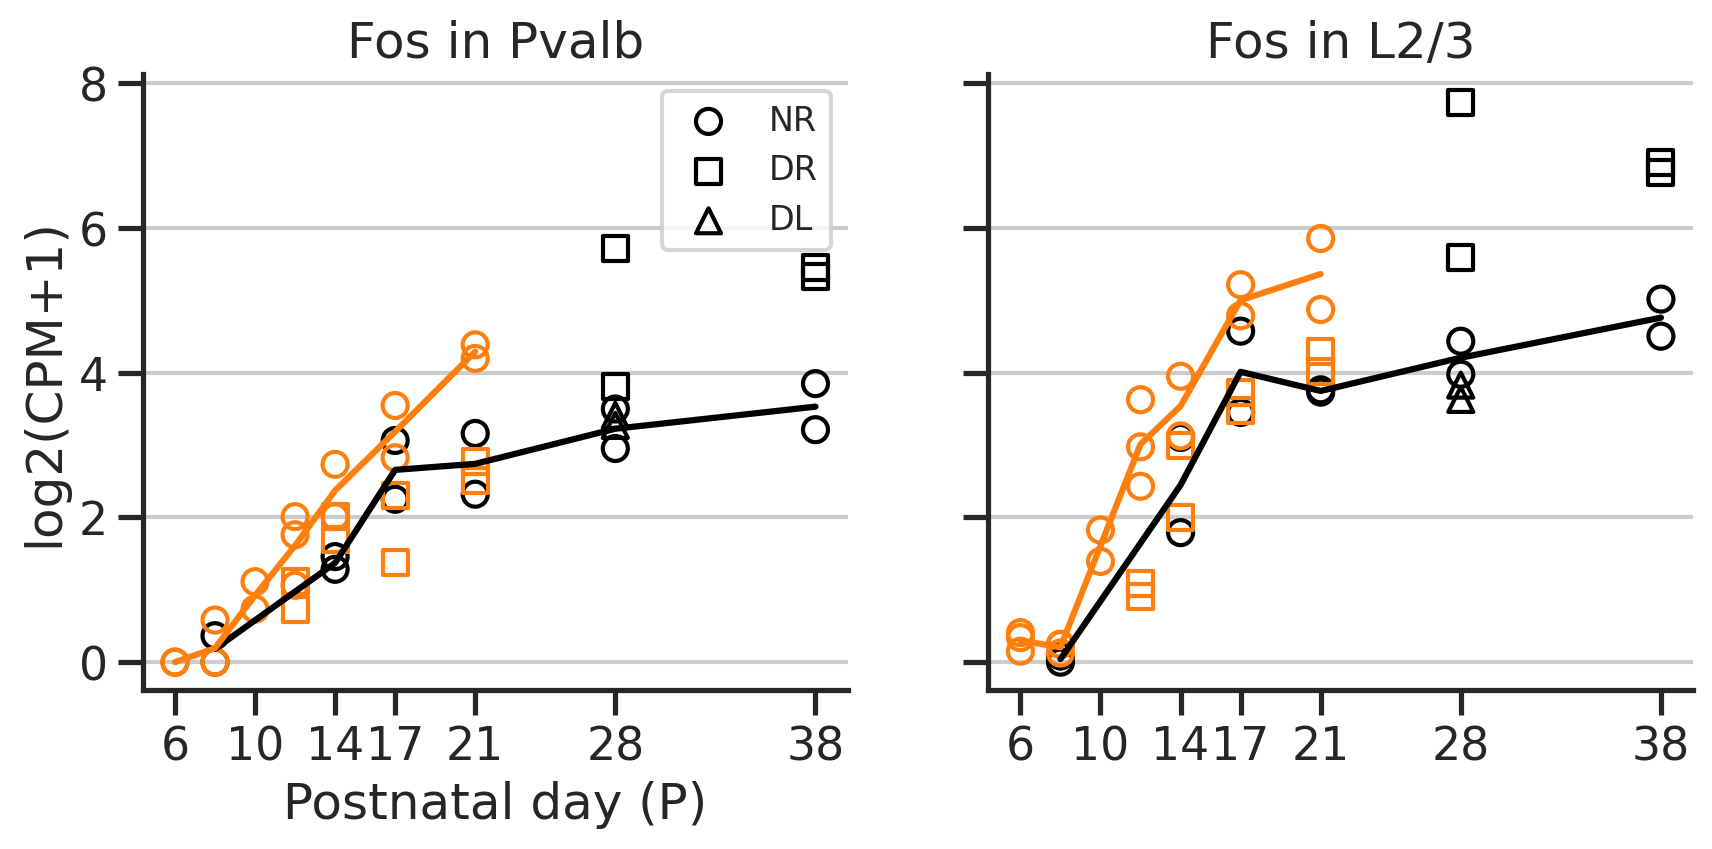

In [8]:
plot_combined(bo0, bo1, 'Fos', 'Pvalb', 'L2/3')

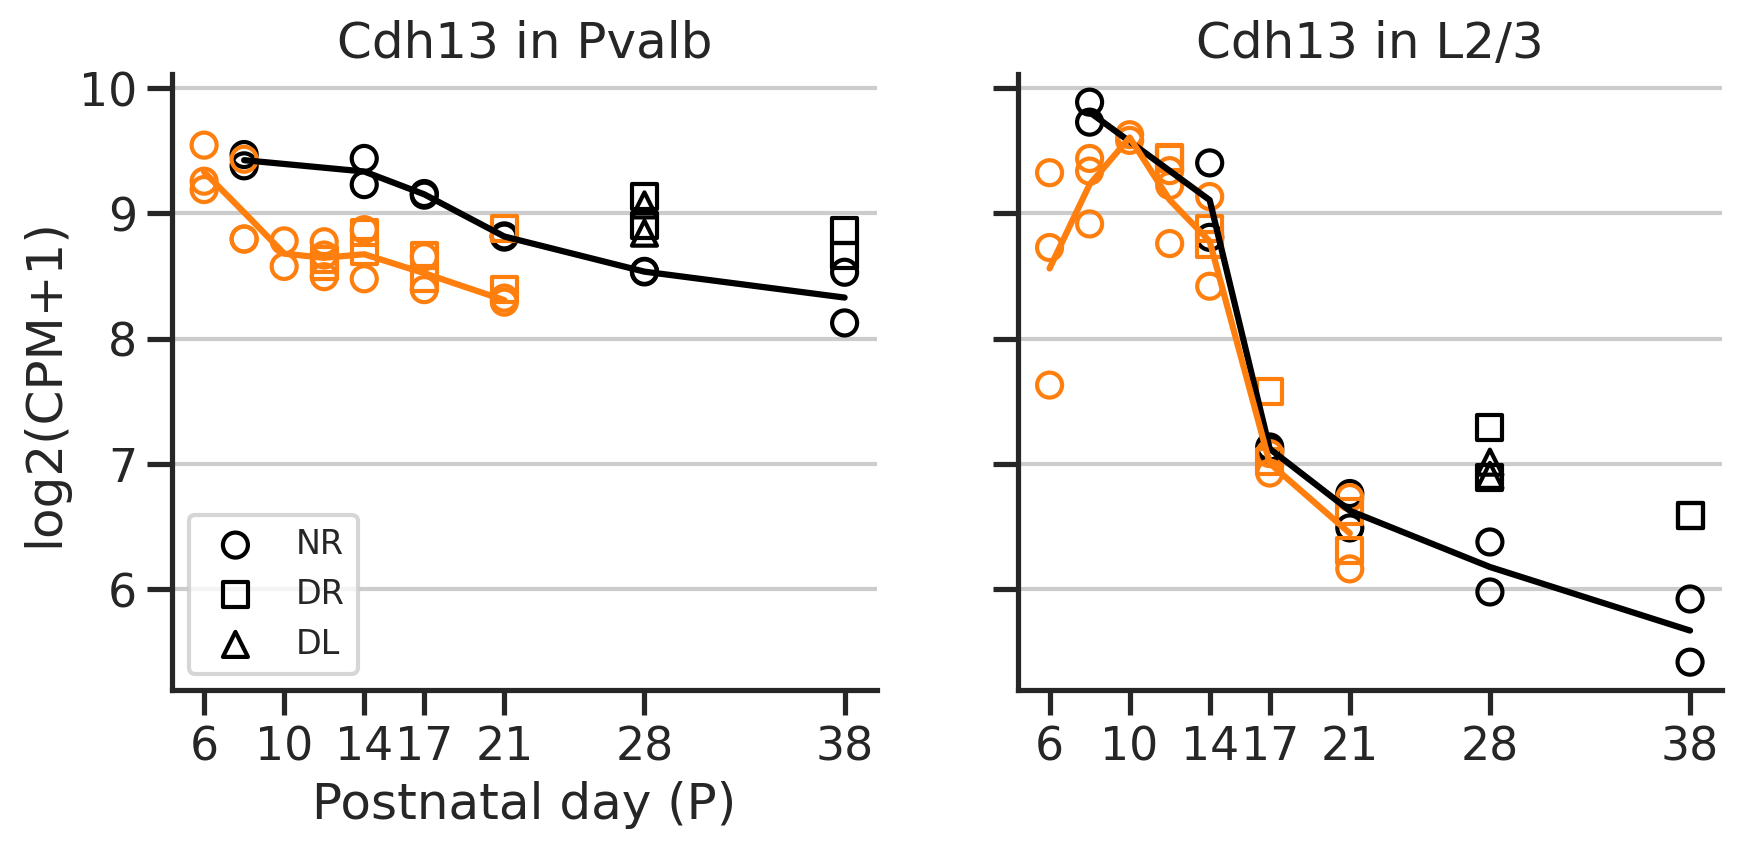

In [9]:
plot_combined(bo0, bo1, 'Cdh13', 'Pvalb', 'L2/3')

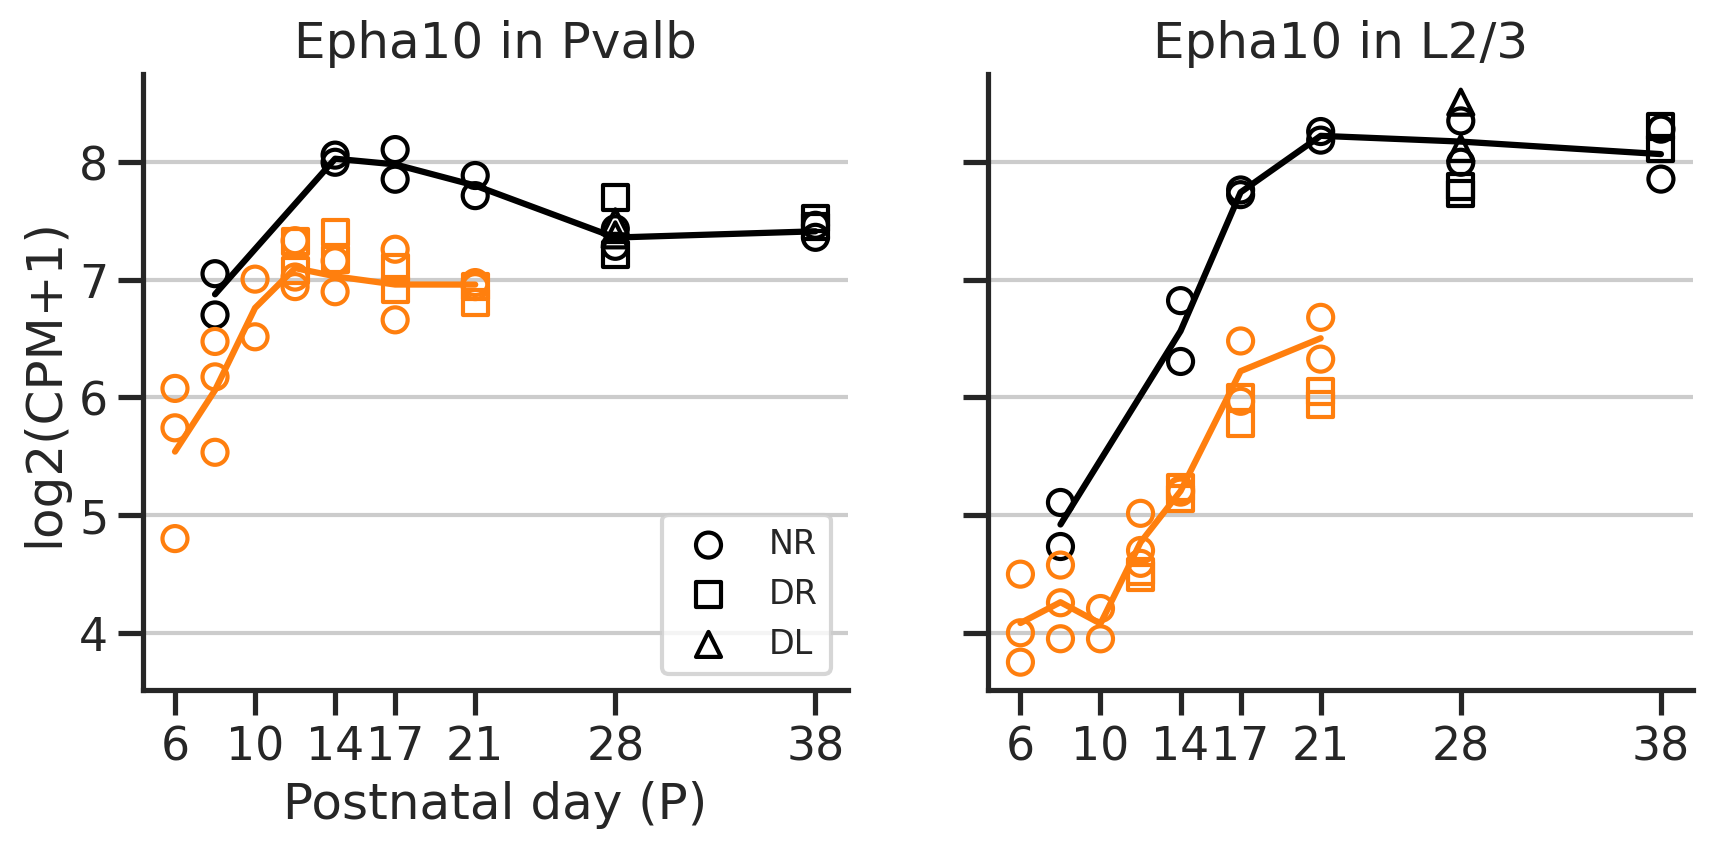

In [10]:
plot_combined(bo0, bo1, 'Epha10', 'Pvalb', 'L2/3')

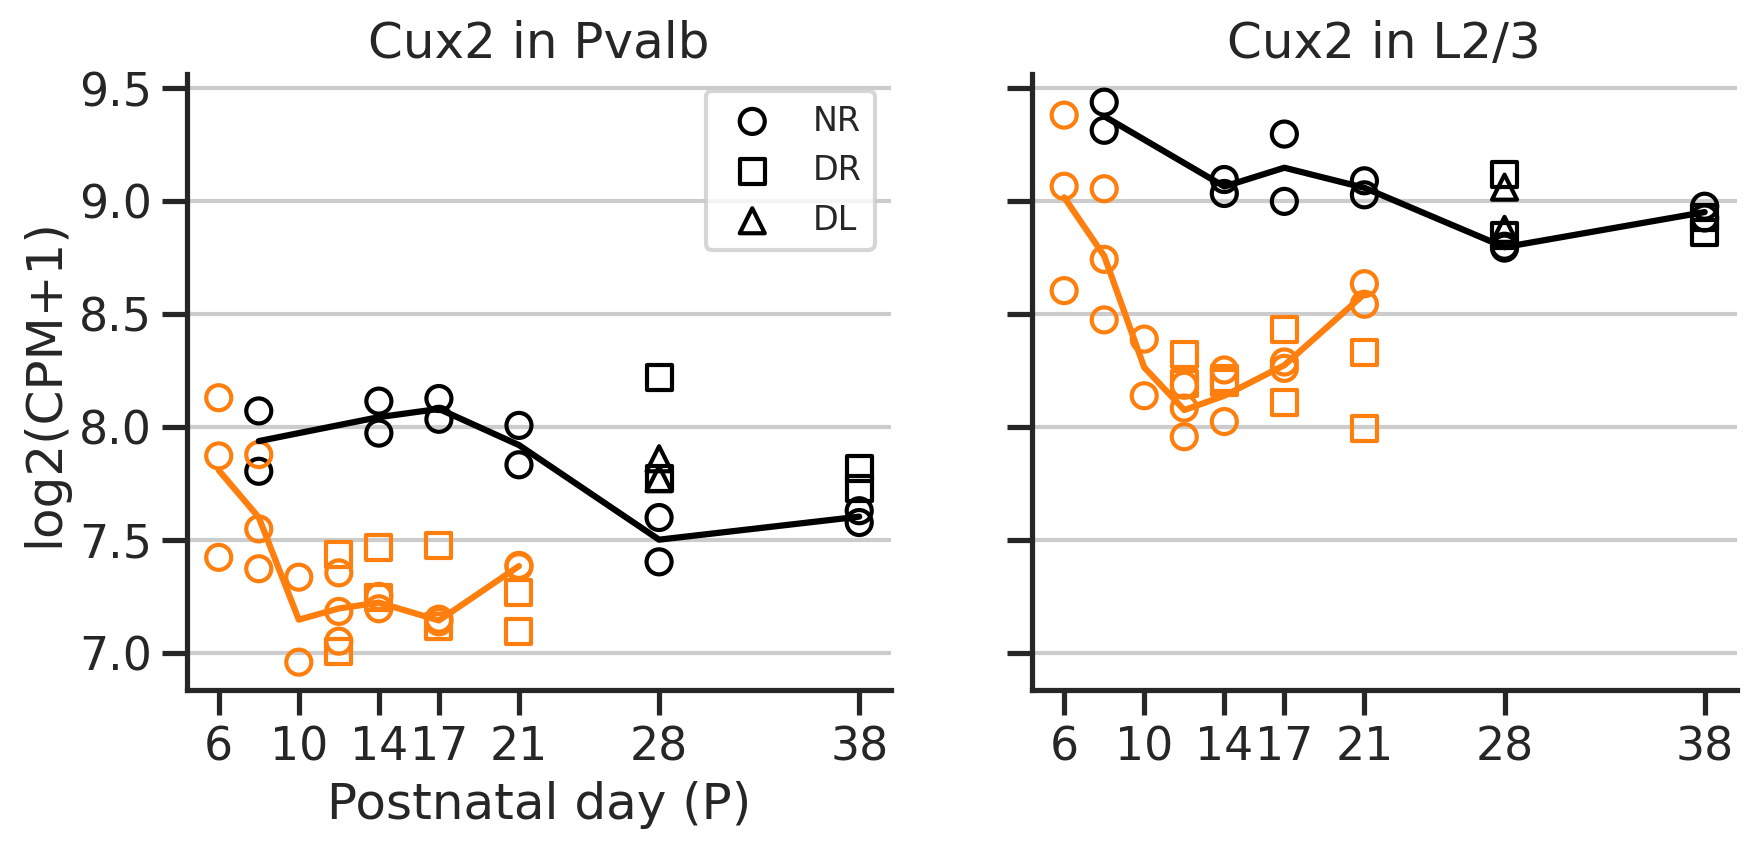

In [11]:
plot_combined(bo0, bo1, 'Cux2', 'Pvalb', 'L2/3')

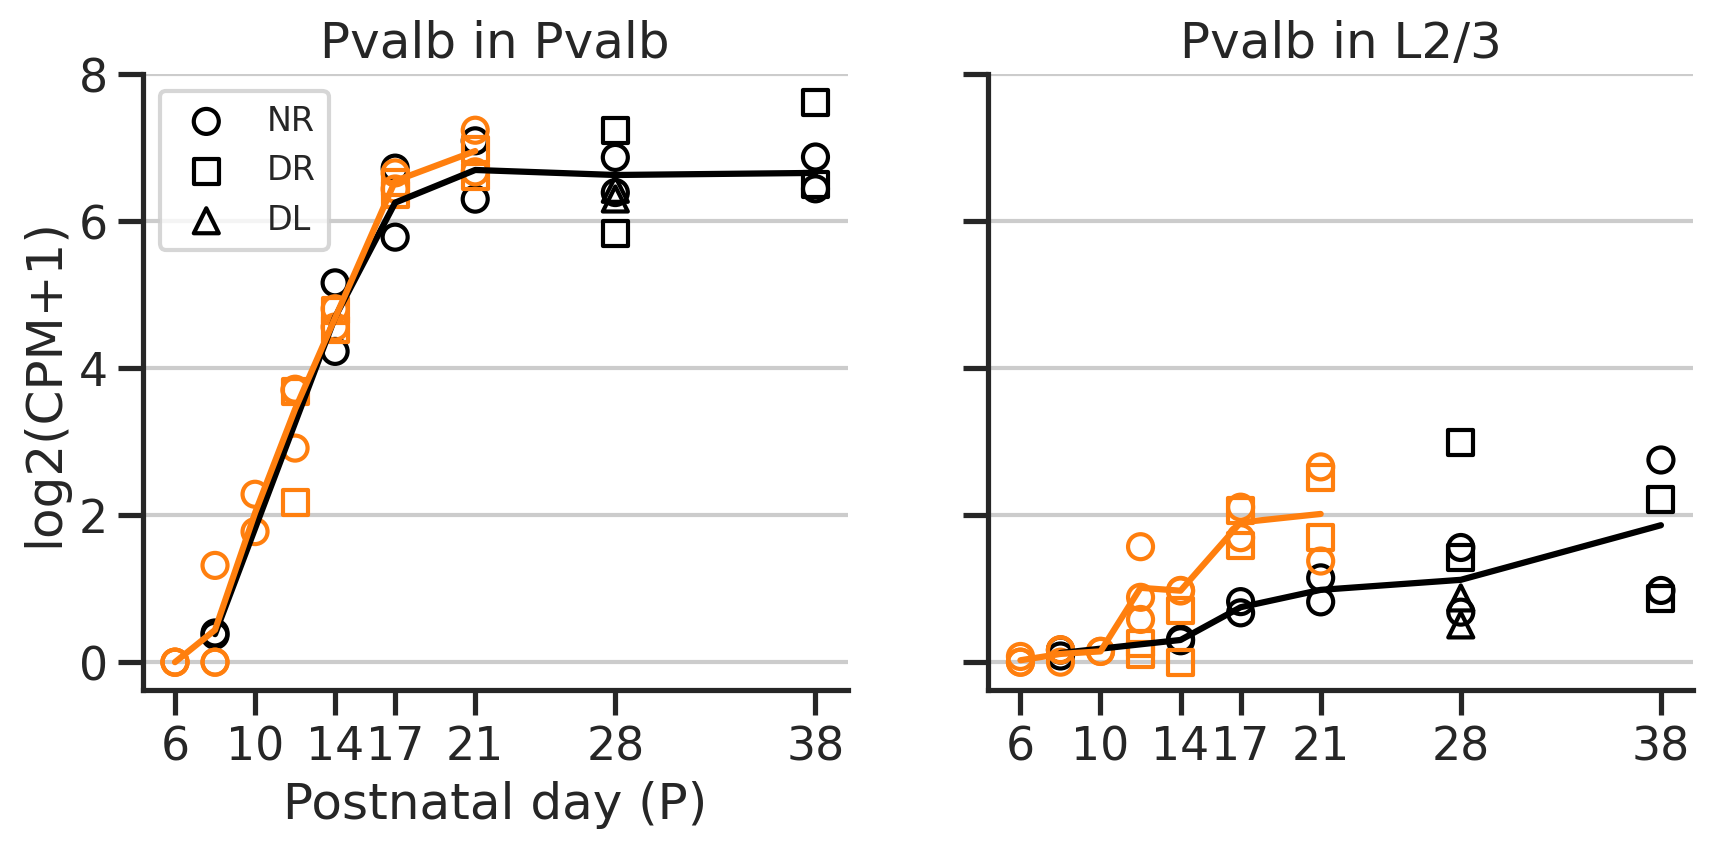

In [12]:
plot_combined(bo0, bo1, 'Pvalb', 'Pvalb', 'L2/3')

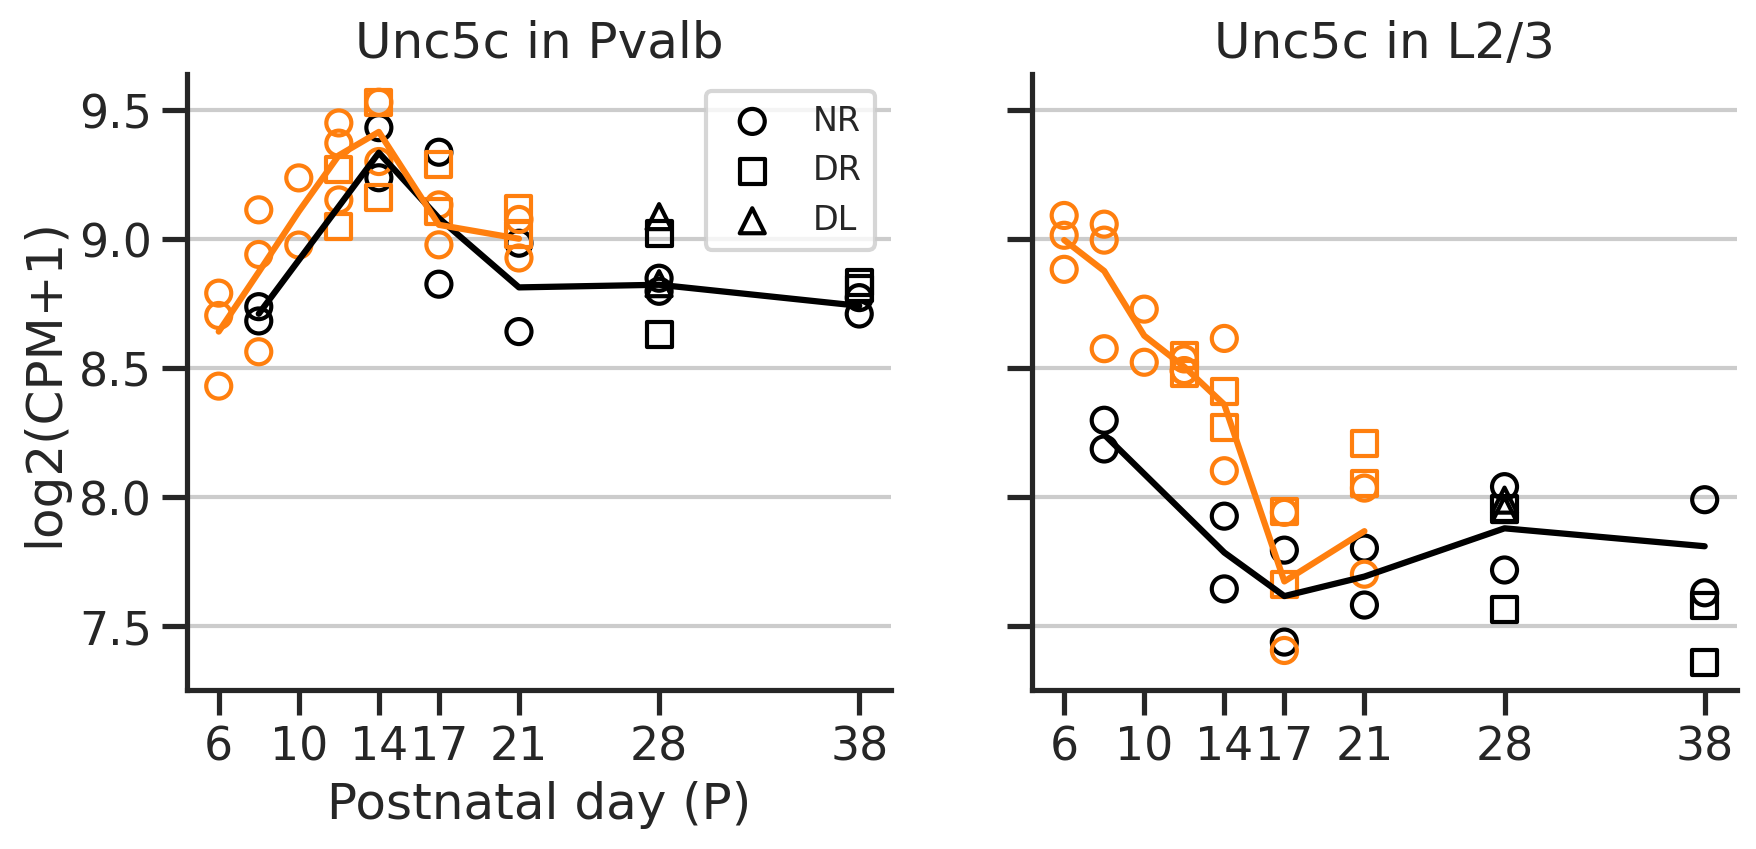

In [13]:
plot_combined(bo0, bo1, 'Unc5c', 'Pvalb', 'L2/3')